<a href="https://colab.research.google.com/github/Camilojaravila/202220_MINE-4210_ANALISIS_CON_DEEP_LEARNING/blob/main/Laboratorio%202/Pr%C3%A1ctica%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)


# **Laboratorio 2 - Sesión 1**
## **Redes Convolucionales**

## **Objetivos**
*   Realizar la carga y procesamiento de imágenes.
*   Analizar la estructura de una Red Neuronal Convolucional.
*   Revisar los diferentes conceptos de las Redes Neuronales Convolucionales.


## **Problema**
- Uno de los grandes avances que se han propuesto a través de la Visión por Computador es la clasificación de imágenes. Donde a través de ellas se puede establecer directamente a que clase o etiqueta pertenece una imágen sin necesidad de intervención humana. Así que para ello, hemos recuperado un conjunto de imágenes que nos ayudará a entender los conceptos básicos de las Redes Convolucionales a través del [Reconocimiento de Flores](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition). 

## 0. Importación de Librerías
Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.7 MB/s 
     |████████████████████████████████| 1.6 MB 31.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, Rescaling, Lambda, MaxPooling2D, Conv2D, AveragePooling2D
from keras import backend as K
from keras import applications
from keras.utils.vis_utils import plot_model

import keras_tuner as kt

from sklearn.metrics import classification_report, confusion_matrix

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.2


## 1. Perfilamiento y entendimiento de los datos

Primero, descargamos los datos y los extraemos dentro de la máquina, al ser imágenes, el peso y el tiempo de descarga puede ser mucho mayor a lo que veníamos manejando al utilizar la plataforma Kaggle. Pueden seguir [el siguiente tutorial](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) para descargar los datos. así ahorrarnos tiempo de conversiones y procesamientos

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download alxmamaev/flowers-recognition
! unzip flowers-recognition.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 91% 205M/225M [00:01<00:00, 158MB/s]
100% 225M/225M [00:01<00:00, 158MB/s]
Archive:  flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg 

Ahora que vamos a utilizar nuevas librerías como [TensorFlow](https://www.tensorflow.org/) y [Keras](https://keras.io/), podemos realizar la carga de nuestros datos de una manera diferente, para que nuestro modelo le sea más fácil entenderlo y procesarlo, y así ahorrarnos tiempo de conversiones y procesamiento. Para ello utilizaremos el modelo [tf.Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

## 2. Preparación de datos

Definimos algunos parámetros, como el tamaño del batch y el tamaño de las imágenes a cargar.

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

utilizaremos la función `image_dataset_from_directory` de TensorFlow, para realizar la carga de nuestras imágenes. Para ello, nos debemos asegurar que nuestra carpeta contenga la siguiente estructura.

```python
main_directory/
    class_a/
        a_image_1.jpg
        a_image_2.jpg
    class_b/
        b_image_1.jpg
        b_image_2.jpg
```

Y con esto garantizado, podemos realizar la división de entrenamiento y test directamente.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/flowers',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/flowers',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


Ya con nuestros Tensores cargados y creados, podemos ver por ejemplo, las clases cargadas.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


Y una muestra de las imágenes que se encuentren redimensionadas al tamaño esperado, y se puedan vizualizar correctamente.

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


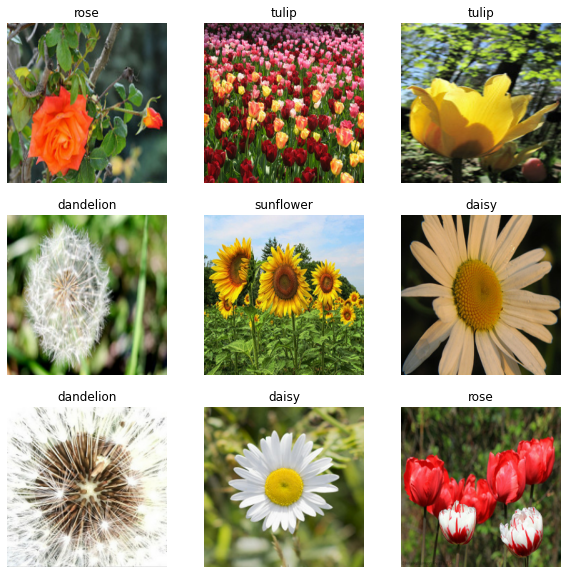

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        print(images[i].numpy().shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

## 3. Modelamiento

Vamos a utilizar la arquitectura de una Red Neuronal Convolucional, la cual se vizualiza de la siguiente manera:

![Redes Convolucionales](https://miro.medium.com/max/700/1*L1NzxHnhto2hn1TaDRoudQ.png)

Para ello, lo primero que definiremos, será nuestro modelo.

In [ ]:
model = Sequential(name="Mi_primer_RNC")

Capas de Preparación de Datos

In [ ]:
model.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Capa_Entrada'))
model.add(Rescaling(1./255,name='Capa_Reescalado'))

model.summary()

Model: "Mi_primer_RNC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Capas de Entrenamiento

In [ ]:
model.add(Conv2D(128, (3, 3), activation='relu', name='Capa_Convolucional_1'))
model.add(MaxPooling2D((2, 2), name='Max_Pool_1'))
model.add(Conv2D(32, (3, 3), activation='relu', name='Capa_Convolucional_2'))
model.add(AveragePooling2D((2, 2), name='Avg_Pool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', name='Capa_Convolucional_3'))
model.summary()

Model: "Mi_primer_RNC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 254, 254, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 127, 127, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 125, 125, 32)     36896     
 D)                                                              
                                                                 
 Avg_Pool_1 (AveragePooling2  (None, 62, 62, 32)       0         
 D)                                                              
                                                     

Capas de Entrenamiento (Perceptron Multicapa)

In [ ]:
model.add(Flatten(name='Flatten_Layer'))
model.add(Dense(100,activation='relu',name='Capa_Densa_1'))
model.add(Dense(50,activation='relu',name='Capa_Densa_2'))
model.summary()

Model: "Mi_primer_RNC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 254, 254, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 127, 127, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 125, 125, 32)     36896     
 D)                                                              
                                                                 
 Avg_Pool_1 (AveragePooling2  (None, 62, 62, 32)       0         
 D)                                                              
                                                     

Capa de Salida

In [ ]:
model.add(Dense(len(class_names),activation='softmax',name='Capa_Respuesta'))
model.summary()

Model: "Mi_primer_RNC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 254, 254, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 127, 127, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 125, 125, 32)     36896     
 D)                                                              
                                                                 
 Avg_Pool_1 (AveragePooling2  (None, 62, 62, 32)       0         
 D)                                                              
                                                     

Ya con nuestra arquitectura construida, compilamos nuestro modelo definiendo que función de pérdida, optimizador y métrica vamos a utilizar para construir nuestro modelo.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "Mi_primer_RNC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 254, 254, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 127, 127, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 125, 125, 32)     36896     
 D)                                                              
                                                                 
 Avg_Pool_1 (AveragePooling2  (None, 62, 62, 32)       0         
 D)                                                              
                                                     

Una manera más amigable de verlo...

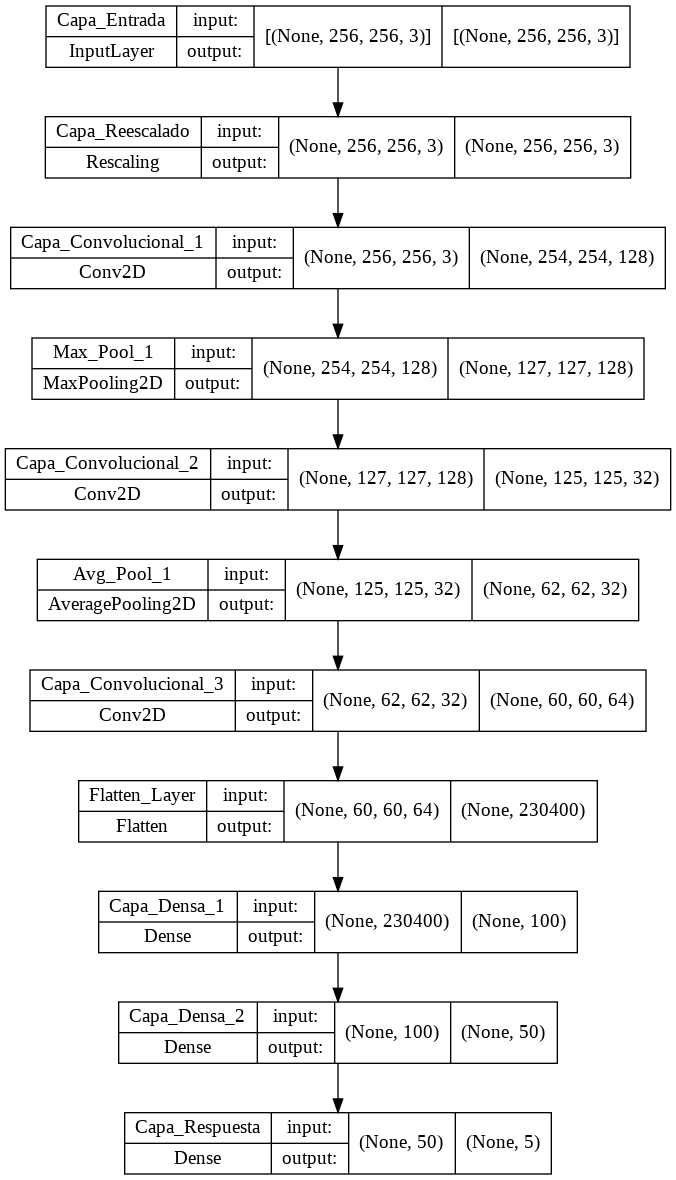

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

Agregamos un Callback de Parada Temprana.

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3)
]

Ya con nuestro modelo construido y compilado. Ahora sí podemos pasar a entrenarlo.

In [ ]:
history = model.fit(train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=my_callbacks
    )

Epoch 1/50
108/108 [==============================] - 888s 8s/step - loss: 1.5203 - precision: 0.6250 - recall: 0.0130 - val_loss: 1.3986 - val_precision: 0.8485 - val_recall: 0.0324
Epoch 2/50
108/108 [==============================] - 854s 8s/step - loss: 1.3545 - precision: 0.6642 - recall: 0.1025 - val_loss: 1.2336 - val_precision: 0.6667 - val_recall: 0.1390
Epoch 3/50
108/108 [==============================] - 856s 8s/step - loss: 1.2330 - precision: 0.6515 - recall: 0.2079 - val_loss: 1.1603 - val_precision: 0.6420 - val_recall: 0.2619
Epoch 4/50
108/108 [==============================] - 953s 9s/step - loss: 1.1155 - precision: 0.6865 - recall: 0.3303 - val_loss: 1.1529 - val_precision: 0.6526 - val_recall: 0.3221
Epoch 5/50
108/108 [==============================] - 868s 8s/step - loss: 1.0619 - precision: 0.7112 - recall: 0.3885 - val_loss: 1.0741 - val_precision: 0.6836 - val_recall: 0.3581
Epoch 6/50
108/108 [==============================] - 857s 8s/step - loss: 1.0160 - p

### 3.1.2. Predicción

Al igual que con nuestros modelos anteriores, podemos realizar las predicciones de nuestro conjunto de datos. Sin embargo, acá hay que realizar una pequeña corrección.

In [ ]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32), array([[0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        ...,
        [0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1]]))

Y utilizaremos nuestro Reporte de Clasificación para poder interpretar los resultados del modelo.

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

       daisy       0.60      0.79      0.68       621
   dandelion       0.69      0.72      0.70       852
        rose       0.60      0.76      0.67       625
   sunflower       0.90      0.75      0.82       585
       tulip       0.91      0.53      0.67       771

   micro avg       0.70      0.70      0.70      3454
   macro avg       0.74      0.71      0.71      3454
weighted avg       0.74      0.70      0.71      3454
 samples avg       0.70      0.70      0.70      3454



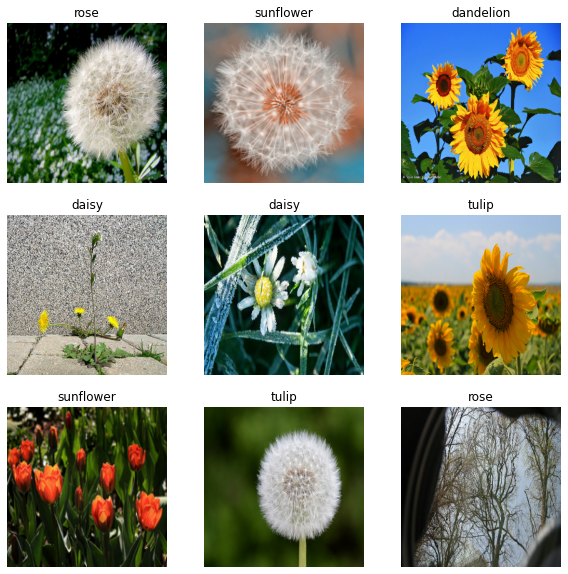

In [ ]:
plt.figure(figsize=(10, 10))

df = train_ds.take(1)
pred = model.predict(df)
for images, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

Adicionalmente, podemos ver como fue el comportamiento de la pérdida y la exactitud a medida que nuestro modelo fue aprendiendo durante las épocas.

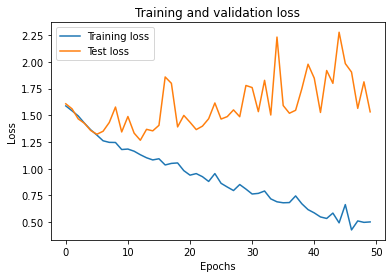

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

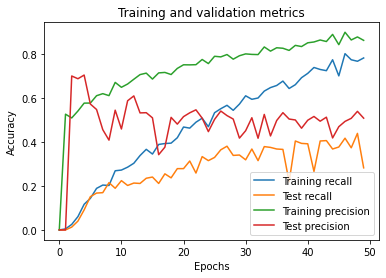

In [ ]:
plt.plot(history.history['recall_1'], label='Training recall')
plt.plot(history.history['val_recall_1'], label='Test recall')
plt.plot(history.history['precision_1'], label='Training precision')
plt.plot(history.history['val_precision_1'], label='Test precision')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 5. Validación

Y podemos realizar los mismos pasos, pero esta vez con nuestros datos de validación.

In [ ]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32), array([[0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        ...,
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]]))

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

       daisy       0.65      0.25      0.36       105
   dandelion       0.41      0.58      0.49       125
        rose       0.33      0.39      0.36       101
   sunflower       0.46      0.69      0.55        95
       tulip       0.34      0.20      0.25       123

   micro avg       0.42      0.42      0.42       549
   macro avg       0.44      0.42      0.40       549
weighted avg       0.43      0.42      0.40       549
 samples avg       0.42      0.42      0.42       549



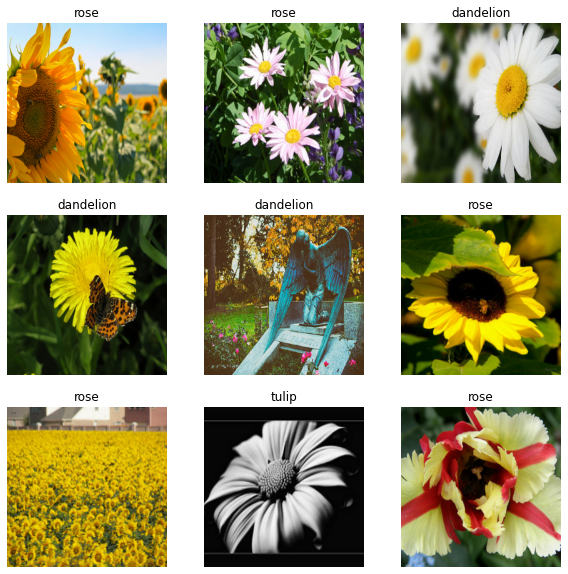

In [ ]:
plt.figure(figsize=(10, 10))

df = val_ds.take(1)
pred = model.predict(df)
for images, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

### Búsqueda de Hiperparámetros

Hay muchos hiperparámetros por entonar en el modelo, podemos seguir utilizando GridSearch. Sin embargo, no lo recomendamos debido a la gran cantidad de hiperparámetros que hay que entrenar. 

Para ello, construimos una función que nos permita construir la Red Neuronal esperada y utilizamos la función [RandomizedSearchCV](https://keras.io/guides/keras_tuner/getting_started/) integrada directamente con Keras.

In [ ]:
def entrenarRed(hp):
    clf = Sequential(name='Red_Encontrada')
    output = len(class_names)
    n_layers_DCN = hp.Choice('n_layers_DCN', [1, 2, 3])
    filtros = hp.Choice('filtros', ['[128, 64, 32]','[200, 100, 50]','[30, 120, 50]'])
    n_layers_MLP = hp.Choice('n_layers_MLP', [1, 2, 3])
    neuronas_MLP = hp.Choice('neuronas_MLP', ['[100, 50, 20]','[10, 20, 30]','[32, 16, 8]'])
    dropout = hp.Choice('dropout', [0.1,0.3,0.5])
    
    filtros = eval(filtros)
    neuronas_MLP = eval(neuronas_MLP)

    clf.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Input_Layer'))
    clf.add(Rescaling(1./255,name='Rescaling_Layer'))

    for i in range(n_layers_MLP):
        clf.add(Conv2D(128, (3, 3), activation='relu', name='Capa_Convolucional_{0}'.format(i)))
        clf.add(MaxPooling2D((2, 2), name='Max_Pool_{0}'.format(i)))

    clf.add(Flatten(name='Flatten_Layer'))
    for i in range(n_layers_MLP):
        clf.add(Dense(neuronas_MLP[i], activation='linear', name = 'Capa_Oculta_MLP_{0}'.format(i)))
        clf.add(Dropout(dropout,name='Dropout_{0}_{1}'.format(dropout,i)))

    clf.add(Dense(output, activation='softmax', name= 'Capa_Respuesta'))

    clf.compile(loss='categorical_crossentropy',
                optimizer='sgd',
                metrics=["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return clf

tuner = kt.RandomSearch(
    entrenarRed,
    objective="val_accuracy",
    project_name="flower_detection",
    seed=123,
    max_trials=10)

Ya con nuestros valores de búsqueda definidos dentro de nuestra función, y nuestro objeto tuner inicializado. Podemor realizar la búsqueda de los hierparámetros como ya hemos venido realizandolo.

**Nota**: Para este paso, utilizamos el GPU de la máquina de Google Colab, con el fin de realizar el proceso de entrenamiento mucho más rapido.

Este fragmento de código, nos permite evaluar si tenemos disponible una GPU dentro del ambiente de Google Colab.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
    with tf.device('/device:GPU:0'): 
    tuner.search(train_ds,
             validation_data=val_ds,
             callbacks=my_callbacks,
             epochs=30)
    
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 04m 44s]
val_accuracy: 0.5724217891693115

Best val_accuracy So Far: 0.658169150352478
Total elapsed time: 01h 00m 01s


Y realizamos la descarga de nuestro modelo, junto con la vizualización de la arquitectura escogida por la búsqueda Aleatoria.

In [ ]:
best_model.save('best_model_flower.h5')
best_model.summary()

Model: "Red_Encontrada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Capa_Convolucional_0 (Conv2  (None, 254, 254, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_0 (MaxPooling2D)   (None, 127, 127, 128)     0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 125, 125, 128)    147584    
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 62, 62, 128)       0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 60, 60, 128)   

Realizamos los mismos pasos que hicimos con nuestro modelo base, para poder comparar 

In [ ]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.]], dtype=float32), array([[0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        ...,
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0]]))

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

In [ ]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

       daisy       0.64      0.66      0.65       143
   dandelion       0.64      0.82      0.72       200
        rose       0.59      0.39      0.47       159
   sunflower       0.81      0.74      0.77       148
       tulip       0.62      0.64      0.63       213

   micro avg       0.66      0.66      0.66       863
   macro avg       0.66      0.65      0.65       863
weighted avg       0.66      0.66      0.65       863
 samples avg       0.66      0.66      0.66       863

              precision    recall  f1-score   support

       daisy       0.64      0.66      0.65       143
   dandelion       0.64      0.82      0.72       200
        rose       0.59      0.39      0.47       159
   sunflower       0.81      0.74      0.77       148
       tulip       0.62      0.64      0.63       213

   micro avg       0.66      0.66      0.66       863
   macro avg       0.66      0.65      0.65       863
weighted avg       0.66

### Preguntas

- ¿Qué pasaría si realizo mi búsqueda a través de otro camino (función de costos, métricas)? ¿Obtendré un mejor resultado?
- ¿Cómo puedo corregir la "reducción" de las dimensiones de las imágenes dentro de cada capa de Pooling?
- ¿Qué otros hiperparámetros podemos ver dentro de las Redes Convolucionales, para que funciona el padding y el tamaño de la convolución?
- Ante la falta de recursos (tiempo, uso de GPU, espacio de búsqueda), ¿Y si utilizamos una red preentrenada? ¿Mejorará el rendimiento de nuestro modelo a un menor tiempo de entrenamiento? ¿Valdrá la pena el cambio?